In [5]:
from PIL import Image

In [40]:
BACKGROUND = 128
WHITE = 255
BLACK = 0
ZERO = 178

In [272]:
standard_blocks_names = list("EFGHIJKL")
standard_blocks = {
    name: np.array(Image.open(f"./blocks/{name}.png")) for name in standard_blocks_names
}

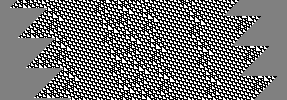

In [273]:
imgI

In [274]:
left_tip = {}

for name, img in standard_blocks.items():
    ydim, xdim = img.shape
    columns = [(img[:, x] == 128).all() for x in range(xdim)]
    tip_col = columns.index(False)
    tip_row = list(img[:, tip_col]).index(255)
    left_tip[name] = (tip_col, tip_row)
left_tip

{'E': (13, 7),
 'F': (11, 7),
 'G': (8, 7),
 'H': (10, 7),
 'I': (10, 7),
 'J': (5, 7),
 'K': (16, 7),
 'L': (10, 7)}

In [275]:
right_hole = {}

for name, img in standard_blocks.items():
    ydim, xdim = img.shape
    columns = [(img[:, x] != 128).all() for x in range(xdim)]
    hole_col = xdim - list(reversed(columns)).index(True)
    hole_row = list(img[:, hole_col]).index(128)
    right_hole[name] = (hole_col, hole_row)
right_hole

{'E': (370, 28),
 'F': (344, 22),
 'G': (348, 3),
 'H': (224, 29),
 'I': (224, 15),
 'J': (243, 21),
 'K': (354, 7),
 'L': (246, 6)}

In [38]:
import numpy as np

arr = np.array(img)

flatten = lambda ll: [x for l in ll for x in l]
set(flatten(arr.tolist()))

{0, 128, 179, 255}

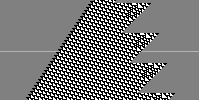

In [39]:
arr.

In [280]:
def glue(A, B, ar, ac, br, bc):
    ay, ax = A.shape
    by, bx = B.shape

    A.shape, B.shape

    a1x, a1y = -ac, -ar
    a2x, a2y = a1x + ax, a1y + ay

    b1x, b1y = -bc, -br
    b2x, b2y = b1x + bx, b1y + by

    c1x = min(a1x, b1x)
    c1y = min(a1y, b1y)

    c2x = max(a2x, b2x)
    c2y = max(a2y, b2y)

    a1x, a2x = a1x - c1x, a2x - c1x
    b1x, b2x = b1x - c1x, b2x - c1x
    c1x, c2x = c1x - c1x, c2x - c1x

    a1y, a2y = a1y - c1y, a2y - c1y
    b1y, b2y = b1y - c1y, b2y - c1y
    c1y, c2y = c1y - c1y, c2y - c1y

    C = np.zeros((c2y, c2x))
    C[a1y:a2y, a1x:a2x] += A
    C[b1y:b2y, b1x:b2x] += B
    
    return C

In [283]:
def glue_blocks(nameA, nameB):
    ac, ar = left_tip[nameA]
    bc, br = right_hole[nameB]
    return glue(
        A=standard_blocks[nameA],
        B=standard_blocks[nameB],
        ar=ar, ac=ac, br=br, bc=bc
    )

In [284]:
glue_blocks("I", "J")

array([[128., 128., 128., ...,   0.,   0.,   0.],
       [128., 128., 128., ...,   0.,   0.,   0.],
       [128., 128., 128., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 128., 128., 128.],
       [  0.,   0.,   0., ..., 128., 128., 128.],
       [  0.,   0.,   0., ..., 128., 128., 128.]])

In [279]:
ac, ar = left_tip[nameA]
bc, br = right_hole[nameB]
glue(
    A=standard_blocks[nameA],
    B=standard_blocks[nameB],
    ar=ar, ac=ac, br=br, bc=bc
)